# Script to read and process netCDF data

## Import libraries

In [1]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import xarray as xr
import rioxarray
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Import shapefile and netCDF data

In [2]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

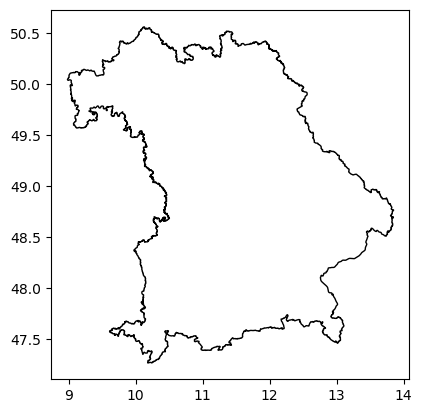

In [3]:
# Load the shapefile
shapefile_path = r"J:\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [4]:
# Open the netCDF file

data = xr.open_dataset('monthly_tmax_average.nc').chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [5]:
data

<xarray.Dataset> Size: 52GB
Dimensions:   (variable: 12, lat: 13920, lon: 39000)
Coordinates:
  * lat       (lat) float64 111kB -56.0 -55.99 -55.98 ... 59.98 59.99 60.0
  * lon       (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Data variables:
    crs       (variable) |S1 12B dask.array<chunksize=(10,), meta=np.ndarray>
    tmax_avg  (variable, lat, lon) float64 52GB dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Degree Celsius [°C] * 10
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream average of monthly maximum temperature
    scale_factor:        10
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

In [6]:
data['tmax_avg']

<xarray.DataArray 'tmax_avg' (variable: 12, lat: 13920, lon: 39000)> Size: 52GB
dask.array<xarray-tmax_avg, shape=(12, 13920, 39000), dtype=float64, chunksize=(10, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   -3.710000e+02 -2.130000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   -2.130000e+02 -5.500000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   -5.500000e+01 1.030000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.030000e+02 2.610000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.610000e+02 4.190000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                monthly_tmax_average
    units:                    Degree Celsius [°C] * 10

## Clip the netCDF data

In [7]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [8]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [9]:
clipped_data

<xarray.Dataset> Size: 22MB
Dimensions:   (lat: 396, lon: 584, variable: 12)
Coordinates:
  * lat       (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon       (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs       int32 4B 0
Dimensions without coordinates: variable
Data variables:
    tmax_avg  (variable, lat, lon) float64 22MB dask.array<chunksize=(10, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Degree Celsius [°C] * 10
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream average of monthly maximum temperature
    scale_factor:        10
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

## Convert xarray to dataframes

In [10]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['tmax_avg'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'tmax_avg' (variable: 12, space: 231264)> Size: 22MB
dask.array<reshape, shape=(12, 231264), dtype=float64, chunksize=(10, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   -3.710000e+02 -2.130000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   -2.130000e+02 -5.500000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   -5.500000e+01 1.030000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.030000e+02 2.610000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.610000e+02 4.190000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                monthly_tmax_average
    units:                    Degree Celsius [°C] * 10

In [11]:
# Prepare the dataframes

# Extract variable
lc_avg = clipped_data['tmax_avg']

# Convert the DataArray to a pandas DataFrame
df = lc_avg.to_dataframe(name='value').reset_index()
display(df)


#pd.options.display.max_rows = 1000
#pd.options.display.min_rows = 500

# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()

display(df_filtered)


,variable,lat,lon,crs,value
0,0,47.270833,8.979167,0,NaN
1,0,47.270833,8.987500,0,NaN
2,0,47.270833,8.995833,0,NaN
3,0,47.270833,9.004167,0,NaN
4,0,47.270833,9.012500,0,NaN
...,...,...,...,...,...
2775163,11,50.562500,13.804167,0,NaN
2775164,11,50.562500,13.812500,0,NaN
2775165,11,50.562500,13.820833,0,NaN
2775166,11,50.562500,13.829167,0,NaN


variable,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,47.270833,8.979167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


variable,index,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,1902,47.295833,10.229167,1.0,14.0,50.0,89.0,135.0,169.0,189.0,184.0,158.0,108.0,48.0,9.0
1,2487,47.304167,10.237500,-2.0,10.0,44.0,83.0,129.0,163.0,184.0,178.0,153.0,104.0,45.0,6.0
2,2488,47.304167,10.245833,-1.0,11.0,45.0,84.0,130.0,163.0,184.0,179.0,153.0,105.0,45.0,7.0
3,3073,47.312500,10.254167,-2.0,10.0,44.0,82.0,129.0,162.0,183.0,178.0,152.0,104.0,45.0,6.0
4,3074,47.312500,10.262500,-1.0,11.0,46.0,84.0,130.0,163.0,184.0,179.0,153.0,105.0,45.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,228480,50.529167,10.112500,8.0,27.0,74.0,118.0,171.0,204.0,217.0,214.0,178.0,118.0,53.0,21.0
16446,228481,50.529167,10.120833,9.0,28.0,75.0,119.0,172.0,205.0,217.0,215.0,179.0,119.0,53.0,22.0
16447,228482,50.529167,10.129167,9.0,28.0,75.0,119.0,172.0,205.0,217.0,215.0,179.0,119.0,54.0,22.0
16448,228484,50.529167,10.145833,9.0,29.0,76.0,120.0,173.0,206.0,218.0,216.0,180.0,120.0,54.0,22.0


In [12]:
df = df_filtered.drop(columns = ['index', 'lat', 'lon'])

In [13]:
temp_dat = df.to_numpy()

In [14]:
temp_dat

array([[  1.,  14.,  50., ..., 108.,  48.,   9.],
       [ -2.,  10.,  44., ..., 104.,  45.,   6.],
       [ -1.,  11.,  45., ..., 105.,  45.,   7.],
       ...,
       [  9.,  28.,  75., ..., 119.,  54.,  22.],
       [  9.,  29.,  76., ..., 120.,  54.,  22.],
       [  9.,  28.,  75., ..., 119.,  54.,  22.]])

In [15]:
temp_all = temp_dat.flatten()

In [16]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.ticker import FuncFormatter, FixedLocator

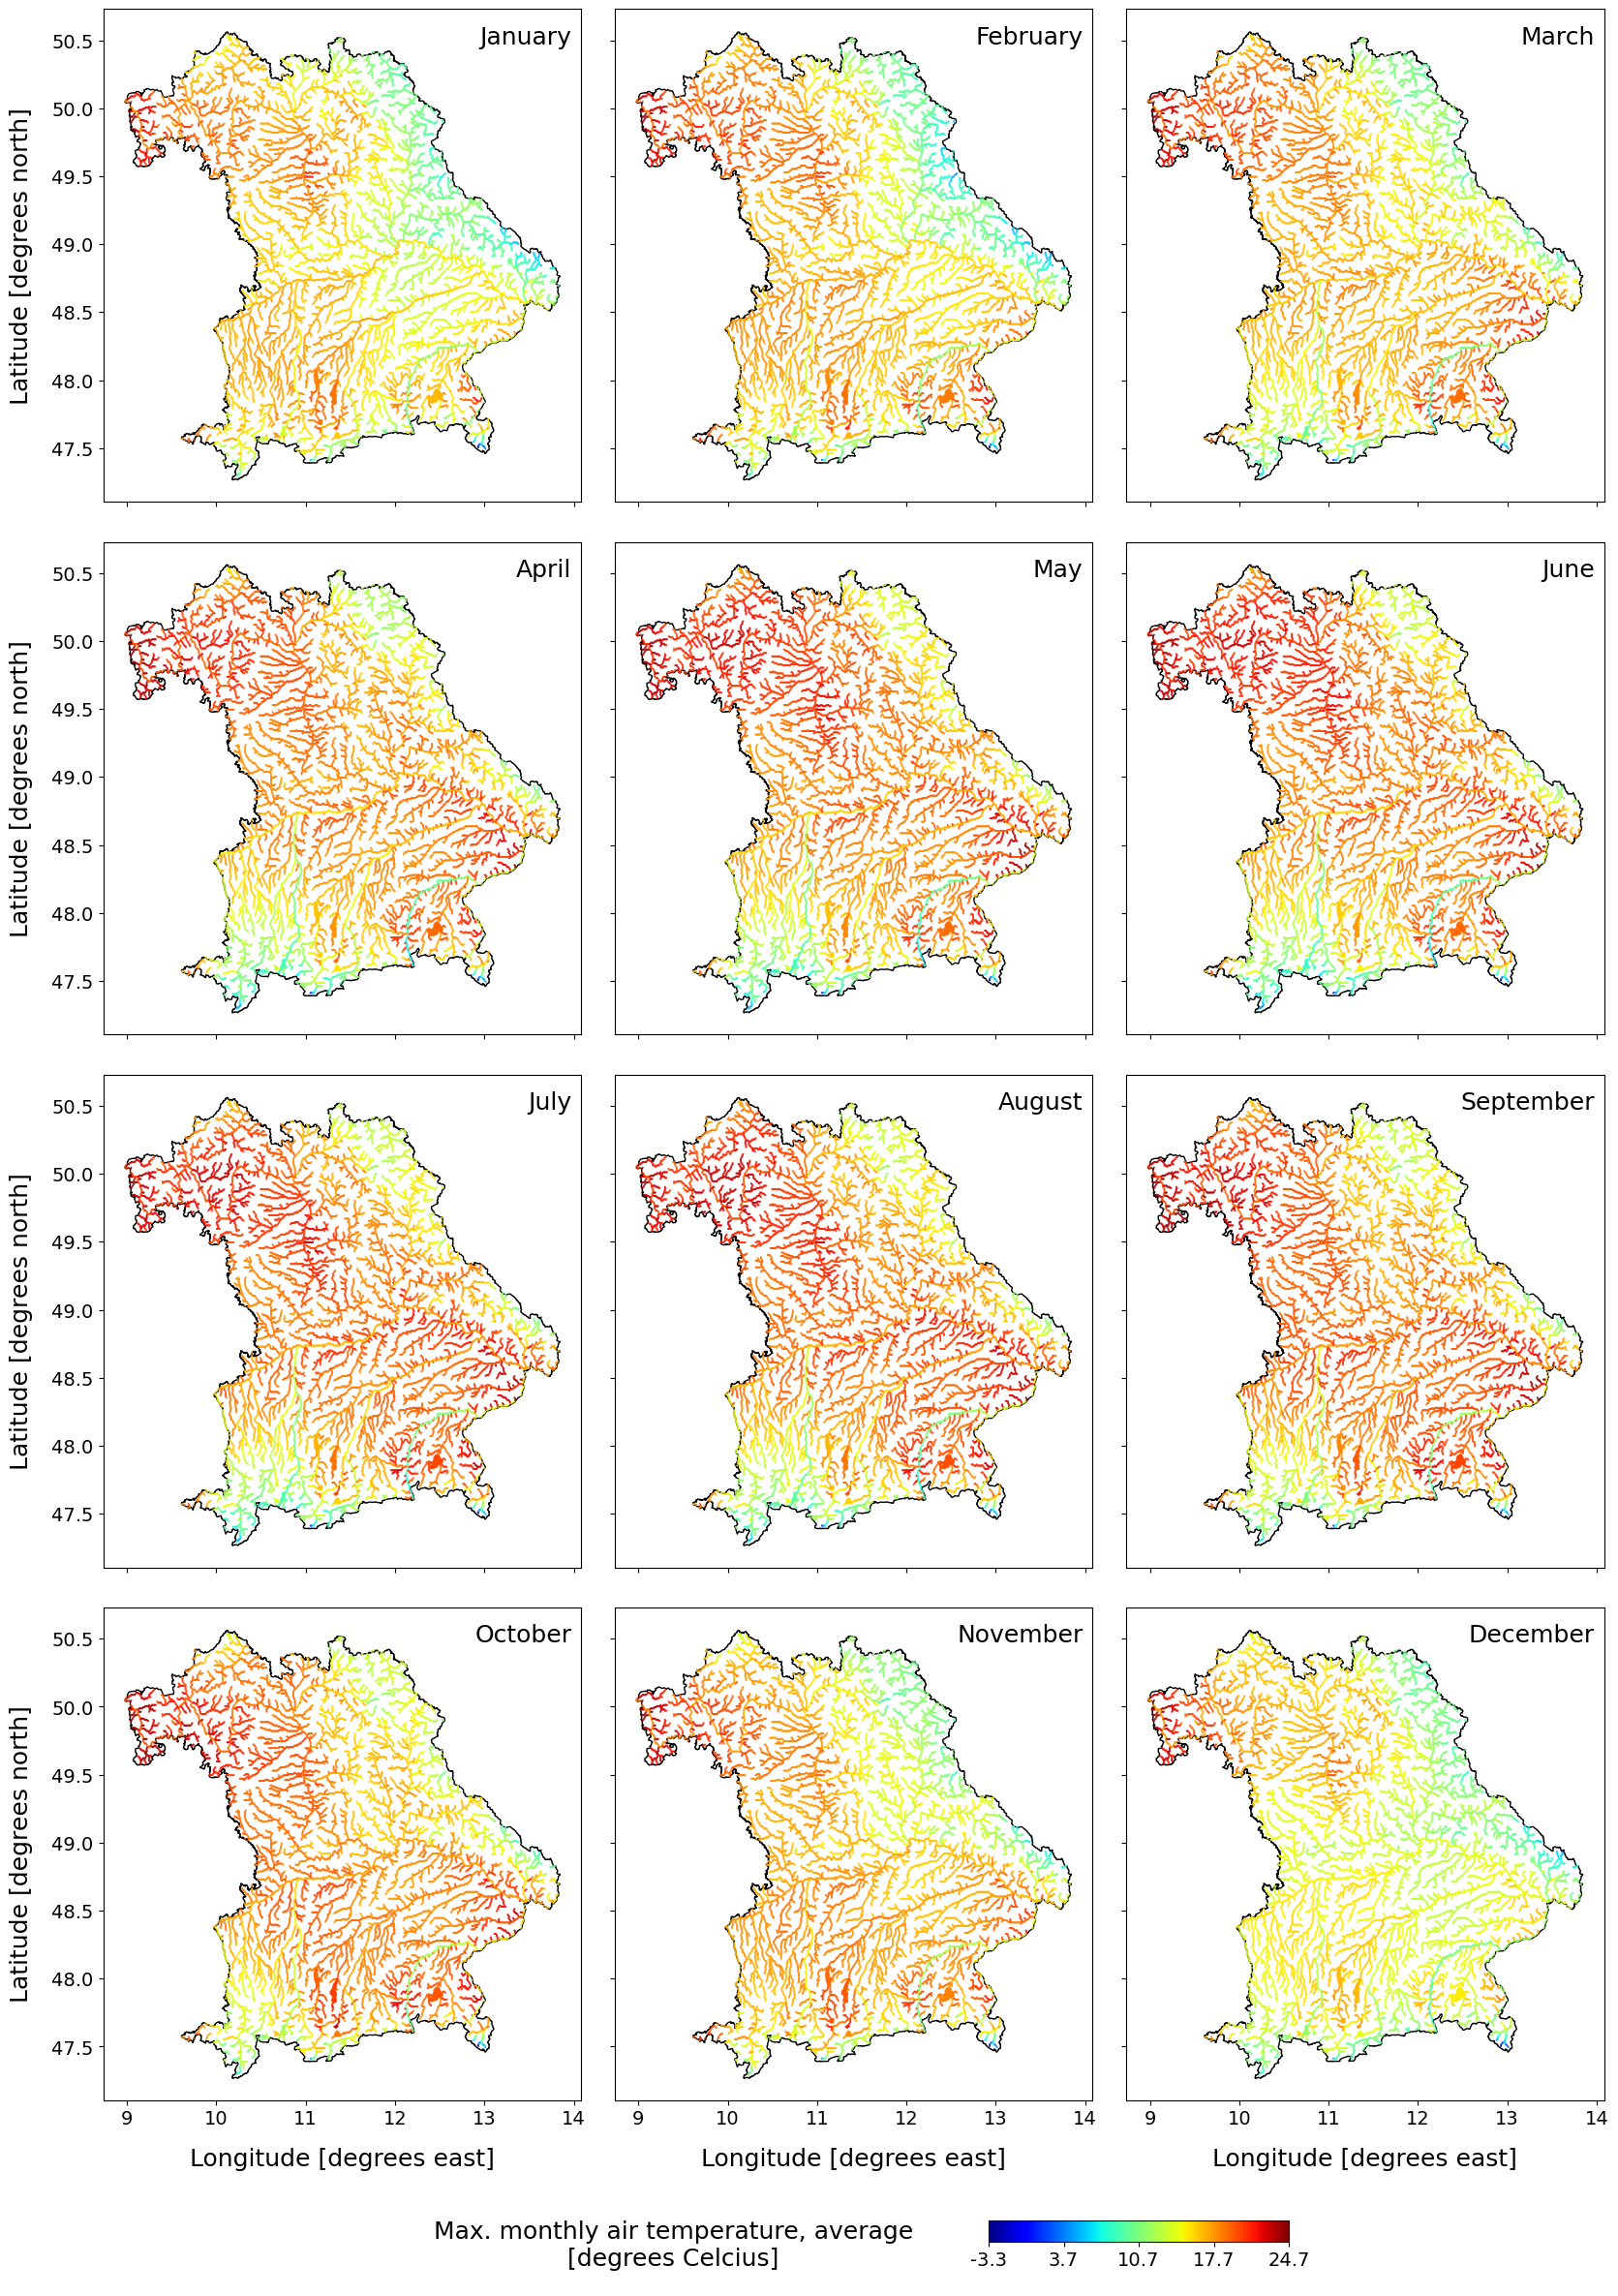

In [19]:
# Create subplots for all the months


row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary


norm = plt.Normalize(vmin=temp_all.min(), vmax=temp_all.max())
fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])

for i in range(13):
# If i is less than 12, then we plot the subplots for available data. If i is 12, we plot the last row of subplot grid and combine all 3 of its columns into a single row. 
# The colorbar and the size legend is then plotted in this last subplot and the borders are then removed.            
    if i < 12:    

        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_filtered.iloc[:,2], df_filtered.iloc[:,1], c=norm(df_filtered.iloc[:,i+3]), cmap='jet', s=0.2)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.59, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = round((temp_all.min()/10), 2)
max_cbar = round((temp_all.max()/10),2)
ticks = np.linspace(temp_all.min(),temp_all.max() , 5).astype(int)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar_ax.text(0.38, 0.2, "Max. monthly air temperature, average\n [degrees Celcius] ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)

# Apply tight layout to subplots only
plt.savefig('stations_monthly_tmax_average_400dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 400)

In [23]:
# save the filtered dataframe
filepath = "df_filtered_tmax_avg"
with open(filepath, 'wb') as file:
    pickle.dump(df_filtered, file)